In [1]:
# Import general python packages used by scientists
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import gc
import os
import pandas as pd

# Import packages  Image Access
import lsst.daf.butler as dafButler
import lsst.geom as geom
from lsst.geom import PointD
from lsst.geom import Point2D
import lsst.afw.display as afwDisplay
import lsst.daf.base as dafBase
from lsst.daf.butler import Butler
import lsst.afw.image as afwImage
import lsst.afw.table as afwTable
from lsst.afw.geom.ellipses import Quadrupole, SeparableDistortionTraceRadius
from lsst.afw import cameraGeom

# Import packages for  Catalog Access
import pandas as pd
pd.set_option('display.max_rows', 1000)
from lsst.rsp import get_tap_service, retrieve_query

#Import custom packages
from ellipticity_mapping import calculate_ellipticity_on_xy
from collection_dictionary_shared import collection_dictionary

from datetime import datetime, timedelta
from astroplan import Observer
from astropy.coordinates import EarthLocation
from astropy.time import Time
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from pytz import all_timezones #To visualize all the possible timezones
from pytz import timezone
import datetime
import time

import lsst.cbp as cbp

In [2]:
timestamp = time.time()  # Example timestamp
datetime_object = datetime.datetime.fromtimestamp(timestamp)
formatted_datetime = datetime_object.strftime("%Y%m%dT%H%M%S")

In [3]:
def remove_figure(fig):
    """
    Remove a figure to reduce memory footprint.

    Parameters
    ----------
    fig: matplotlib.figure.Figure
        Figure to be removed.

    Returns
    -------
    None
    """
    # get the axes and clear their images
    for ax in fig.get_axes():
        for im in ax.get_images():
            im.remove()
    fig.clf()       # clear the figure
    plt.close(fig)  # close the figure
    gc.collect()    # call the garbage collector
    
def pixel_to_camera(x, y, det):
    """
    Parameters
    ----------
    x, y : array
        Pixel coordinates.
    det : lsst.afw.cameraGeom.Detector
        Detector of interest.
    Returns
    -------
    cam_x, cam_y : array
        Focal plane position in millimeters in DVCS
        See https://lse-349.lsst.io/
    """
    tx = det.getTransform(cameraGeom.PIXELS, cameraGeom.FOCAL_PLANE)
    cam_x, cam_y = tx.getMapping().applyForward(np.vstack((x, y)))
    return cam_x.ravel(), cam_y.ravel()

def pixel_to_camera_angle(x, y, det):
    """
    Parameters
    ----------
    x, y : array
        Pixel coordinates.lsst afw.detectordetectordetectordetector
    det : lsst.afw.cameraGeom.Detector
        Detector of interest.
    Returns
    -------
    cam_x, cam_y : array
        Focal plane position in degrees in DVCS
        See https://lse-349.lsst.io/
    """
    tx = det.getTransform(cameraGeom.PIXELS, cameraGeom.FIELD_ANGLE)
    cam_x, cam_y = tx.getMapping().applyForward(np.vstack((x, y)))
    return np.degrees(cam_x.ravel()), np.degrees(cam_y.ravel())

In [4]:
print("POTREI LEGGERE QUESTE COSE DA YAML (COMPRESA ROTAZIONE)???")
seqnums = [91]
detectors = list(np.arange(189))
detectors.remove(25)
detectors.remove(170)
format_figures = 'pdf'

POTREI LEGGERE QUESTE COSE DA YAML (COMPRESA ROTAZIONE)???


In [5]:
# seqnum_rot0 = [91]
# seqnum_rot30 = [92]
# seqnum_rot60 = [98]

# seqnum_rot0 = [96]
# seqnum_rot30 = [97]
# seqnum_rot60 = [99]

seqnum_rot0 = [103]
seqnum_rot30 = [104]
seqnum_rot60 = [105]

In [6]:
collection_dict = collection_dictionary()

In [7]:
folder = '/sdf/data/rubin/shared/image_quality/imsim/'
#Define the butler data configuration and collection (una tantum )
config = folder+'repo'
folderout = folder+'ellipticitymap/'
subfolderout_fig = 'figures/'
subfolderout_tab = 'tables/'

In [8]:
# Saves to a file the information (seqnum, detector and collection) 
# associated to each run of this notebook and each output file
filedict = open(folderout+'mean_ellipticity_dictionary', 'a')  # append mode

for seq in seqnums:
    for det in detectors:
        collection = collection_dict[seq]
        filedict.write('{:s} {:d} {:d} {:s}\n'.format('mean_ellipticities_'+formatted_datetime+'.csv', 
                                                 seq, det, collection))

filedict.close()

In [9]:
do_make_figures_calexp = True
do_make_ellipticity_in_the_center = True
do_make_mean_ellipticity = True
do_ellipticity_on_focalplane = True
regular_grid_or_star_positions = 1 # parametro per l'ellitticità su singolo detector 0: calcolo e su griglia; 1: calcolo e su posizioni stelle
n_grid = 3

do_figure_wcs = False
do_figure_bkg = False
do_figure_psf = False
do_fits_preview = False

# OUTPUT ELLITTICITÀ MEDIE SUI DETECTOR
detector_output = []
seqnum_output = []
mean_e_output = []
median_e_output = []
std_e_output = []
min_e_output = []
max_e_output = []
xx_mean_output = []
yy_mean_output = []
xx_mm_output = []
yy_mm_output = []

x_centro_detector = 2000.
y_centro_detector = 2000.

for seqnum in seqnum_rot0:

    xx_star_all_cam = []
    yy_star_all_cam = []    
    ra_star_all_cam = []
    dec_star_all_cam = []

    e_det_output = []
    ex_det_output = []
    ey_det_output = []
    ex_rot_cam_output = []
    ey_rot_cam_output = []
    theta_cam_output = []
    xx_cam_output = [] #coordinate x su detector
    yy_cam_output = [] #coordinate x su detector
    xx_mm_cam_output = [] #coordinate x su camera
    yy_mm_cam_output = [] #coordinate y su camera
    seqnum_cam_output = []
    detector_cam_output = []
    
    for detector in detectors:
        
        visit_seqnum = 5023071800000 + seqnum
        
        print(seqnum, detector)

        collection = collection_dict[seqnum]

        # Create the butler
        butler = dafButler.Butler(config,collections=collection)

        #Adesso dobbiammo dire al butler che tipo di dati vogliamo.
        #La call si fa chiedendo un datasetType (e.g., deepCoadd, calexp, objectTable) e un data ID(is a dictionary-like identifier for a specific data product)
        #Qui piu' informazioni sul butler 
        #https://github.com/rubin-dp0/tutorial-notebooks/blob/main/04b_Intermediate_Butler_Queries.ipynb

        datasetType='calexp'
        dataId = {'visit': visit_seqnum, 'detector': detector, 'band':'r'}
        calexp = butler.get(datasetType, **dataId)
        sources = butler.get('src', dataId)
        psf = calexp.getPsf()
        bkgd = butler.get('calexpBackground', **dataId)
        ccd = calexp.detector.getId()
        det = calexp.getDetector()
        wcs = calexp.getWcs()
        calexp_info = calexp.getInfo()

        rot = (calexp.info.getVisitInfo().getBoresightRotAngle()).asDegrees()

        rot_from_imsim = 0.

        ################
        # Mappa di stelle sul piano focale
        ################

        if True:
            xx_star = [l.getCentroid()[0] for l in sources]
            yy_star = [l.getCentroid()[1] for l in sources]
            ra_star = [l.getRa().asDegrees() for l in sources]
            dec_star = [l.getDec().asDegrees() for l in sources]

            # Ciclo sulle sources
            for xxx, yyy, raa, decc in zip(xx_star, yy_star, ra_star, dec_star):
                coo = wcs.pixelToSky(xxx, yyy)
                point = geom.Point2D(xxx, yyy)
                cam_x, cam_y = pixel_to_camera_angle(point[0], point[1], det)
                xx_star_all_cam.append(cam_x[0])
                yy_star_all_cam.append(cam_y[0])
                ra_star_all_cam.append(raa)
                dec_star_all_cam.append(decc)

                Ixx = psf.computeShape(point).getIxx()
                Iyy = psf.computeShape(point).getIyy()
                Ixy = psf.computeShape(point).getIxy()
                theta = np.arctan2(2. * Ixy, Ixx - Iyy) / 2.
                e1 = (Ixx - Iyy) / (Ixx + Iyy)
                e2 = (2. * Ixy) / (Ixx + Iyy)
                e = np.sqrt(e1**2 + e2**2)
                ex = e * np.cos(theta)
                ey = e * np.sin(theta)
                ex_rot = ex*np.cos(np.radians(rot_from_imsim)) - ey*np.sin(np.radians(rot_from_imsim))
                ey_rot = ex*np.sin(np.radians(rot_from_imsim)) + ey*np.cos(np.radians(rot_from_imsim))
                theta_cam = np.arctan2(ex, ey) #IMPORTANTE INVERTIRE XY TRA DETECTOR E FP

                e_det_output.append(e)
                ex_det_output.append(ey) #IMPORTANTE INVERTIRE XY TRA DETECTOR E FP
                ey_det_output.append(ex) #IMPORTANTE INVERTIRE XY TRA DETECTOR E FP
                theta_cam_output.append(theta_cam)
                xx_cam_output.append(coo[1].asDegrees()) #IMPORTANTE INVERTIRE XY TRA DETECTOR E FP
                yy_cam_output.append(coo[0].asDegrees()) #IMPORTANTE INVERTIRE XY TRA DETECTOR E FP
                xx_mm_cam_output.append(cam_y[0]) #IMPORTANTE INVERTIRE XY TRA DETECTOR E FP
                yy_mm_cam_output.append(cam_x[0]) #IMPORTANTE INVERTIRE XY TRA DETECTOR E FP
                seqnum_cam_output.append(seqnum)
                detector_cam_output.append(detector)


103 0
103 1
103 2
103 3
103 4
103 5
103 6
103 7
103 8
103 9
103 10
103 11
103 12
103 13
103 14
103 15
103 16
103 17
103 18
103 19
103 20
103 21
103 22
103 23
103 24
103 26
103 27
103 28
103 29
103 30
103 31
103 32
103 33
103 34
103 35
103 36
103 37
103 38
103 39
103 40
103 41
103 42
103 43
103 44
103 45
103 46
103 47
103 48
103 49
103 50
103 51
103 52
103 53
103 54
103 55
103 56
103 57
103 58
103 59
103 60
103 61
103 62
103 63
103 64
103 65
103 66
103 67
103 68
103 69
103 70
103 71
103 72
103 73
103 74
103 75
103 76
103 77
103 78
103 79
103 80
103 81
103 82
103 83
103 84
103 85
103 86
103 87
103 88
103 89
103 90
103 91
103 92
103 93
103 94
103 95
103 96
103 97
103 98
103 99
103 100
103 101
103 102
103 103
103 104
103 105
103 106
103 107
103 108
103 109
103 110
103 111
103 112
103 113
103 114
103 115
103 116
103 117
103 118
103 119
103 120
103 121
103 122
103 123
103 124
103 125
103 126
103 127
103 128
103 129
103 130
103 131
103 132
103 133
103 134
103 135
103 136
103 137
103 138
103 1

In [10]:
e_det_output_series = pd.Series(e_det_output)
xx_mm_cam_output_series = pd.Series(xx_mm_cam_output)
yy_mm_cam_output_series = pd.Series(yy_mm_cam_output)
ex_det_output_series = pd.Series(ex_det_output)
ey_det_output_series = pd.Series(ey_det_output)
theta_cam_output_series = pd.Series(theta_cam_output)
xx_cam_output_series = pd.Series(xx_cam_output)
yy_cam_output_series = pd.Series(yy_cam_output)
seqnum_cam_output_series = pd.Series(seqnum_cam_output)
detector_cam_output_series = pd.Series(detector_cam_output)
seqnum_cam_output_series = pd.Series(seqnum_cam_output)

ind_high_ell = e_det_output_series < 0.5 #Non si capisce perchè alcune vengono così alte.. forse sono sul bordo??

e_det_output_selected = e_det_output_series[ind_high_ell].values
ex_det_output_selected = ex_det_output_series[ind_high_ell].values
ey_det_output_selected = ey_det_output_series[ind_high_ell].values
theta_cam_output_selected = theta_cam_output_series[ind_high_ell].values
xx_cam_output_selected = xx_cam_output_series[ind_high_ell].values
yy_cam_output_selected = yy_cam_output_series[ind_high_ell].values
xx_mm_cam_output_selected = xx_mm_cam_output_series[ind_high_ell].values
yy_mm_cam_output_selected = yy_mm_cam_output_series[ind_high_ell].values
seqnum_cam_output_selected = seqnum_cam_output_series[ind_high_ell].values
detector_cam_output_selected = detector_cam_output_series[ind_high_ell].values
seqnum_cam_output_selected = seqnum_cam_output_series[ind_high_ell].values

104 36
104 56
104 143
[ 1.73472348e-18  2.34187669e-17 -7.80625564e-18  1.56125113e-17
 -1.82145965e-17  4.59701721e-17  5.59448321e-17  3.64291930e-17
  3.46944695e-18 -8.67361738e-18  6.07153217e-17  1.02348685e-16
  4.51028104e-17  8.50014503e-17  9.71445147e-17  3.46944695e-18
  1.14491749e-16  6.24500451e-17  5.89805982e-17  7.28583860e-17
 -1.73472348e-17 -3.46944695e-18  5.20417043e-18  2.77555756e-17
 -1.56125113e-17  1.07552856e-16  2.77555756e-17  3.81639165e-17
 -1.73472348e-17 -1.38777878e-17]
[ 4.51028104e-17  7.80625564e-17  4.16333634e-17  2.08166817e-17
 -1.38777878e-17  1.73472348e-17 -3.46944695e-18  1.24900090e-16
 -4.16333634e-17  5.55111512e-17  6.24500451e-17 -2.81892565e-17
  1.56125113e-17 -1.77809156e-17  0.00000000e+00 -4.16333634e-17
 -4.33680869e-18 -5.37764278e-17  3.29597460e-17 -8.67361738e-18
  3.46944695e-17 -1.34441069e-17  5.55111512e-17  3.46944695e-17
  3.98986399e-17  5.20417043e-17  4.85722573e-17  4.16333634e-17
  5.89805982e-17 -1.38777878e-17]


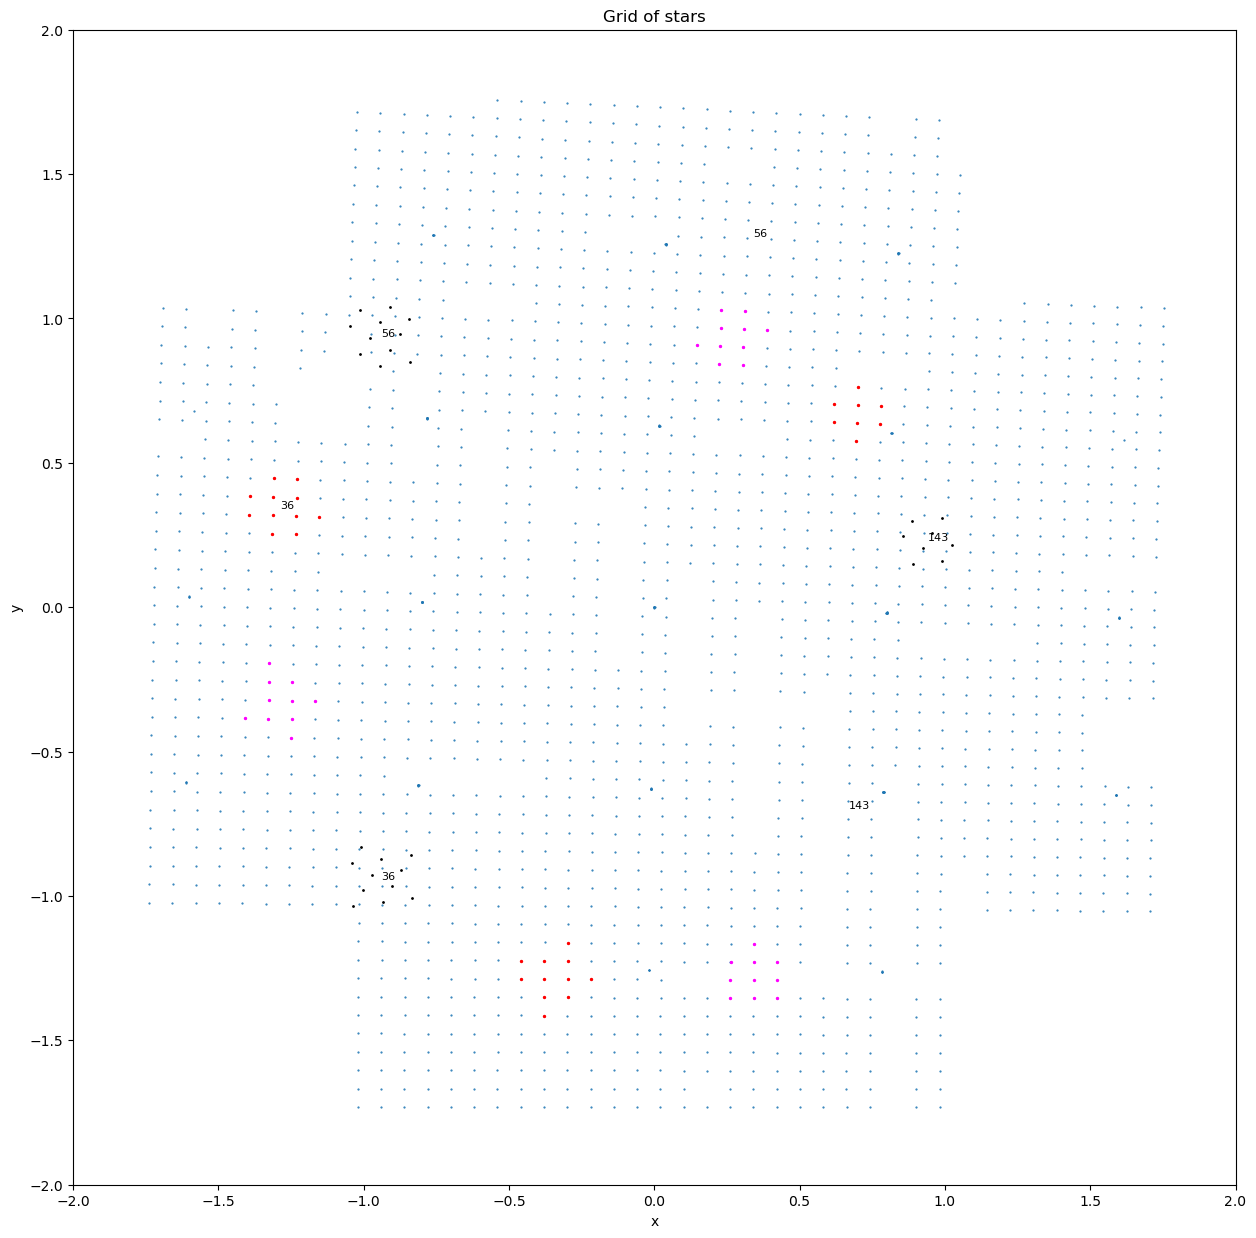

In [11]:
detectors_to_rotate = [36, 56, 143]
for seqnum in seqnum_rot30:

    # _84 indica le proprietà in quelle situazioni nelle quali la camera è stata ruotata di 30°
    xx_star_all_cam_30 = []
    yy_star_all_cam_30 = []
    ra_star_all_cam_30 = []
    dec_star_all_cam_30 = []
    xx_mm_cam_output_30 = []
    yy_mm_cam_output_30 = []
    e_det_output_30_rot = []
    ex_det_output_30_rot = []
    ey_det_output_30_rot = []
    ex_rot_cam_output_30_rot = []
    ey_rot_cam_output_30_rot = []
    theta_cam_output_30_rot = []
    xx_cam_output_30_rot = [] #coordinate x su detector
    yy_cam_output_30_rot = [] #coordinate x su detector
    xx_mm_cam_output_30_rot = [] #coordinate x su camera
    yy_mm_cam_output_30_rot = [] #coordinate y su camera
    seqnum_cam_output_30_rot = []
    detector_cam_output_30_rot = []
    xx_star_all_cam_30_rot = []
    yy_star_all_cam_30_rot = []
    ex_det_output_30_rot2 = []
    ey_det_output_30_rot2 = []
    e_det_output_30_rot2 = []

    x_center_detector_cam = []
    y_center_detector_cam = []
    x_center_detector_cam_dvcs = []
    y_center_detector_cam_dvcs = []
    
    for detector in detectors_to_rotate:
        
        visit_seqnum = 5023071800000 + seqnum
        
        print(seqnum, detector)

        collection = collection_dict[seqnum]

        # Create the butler
        butler = dafButler.Butler(config,collections=collection)

        #Adesso dobbiammo dire al butler che tipo di dati vogliamo.
        #La call si fa chiedendo un datasetType (e.g., deepCoadd, calexp, objectTable) e un data ID(is a dictionary-like identifier for a specific data product)
        #Qui piu' informazioni sul butler 
        #https://github.com/rubin-dp0/tutorial-notebooks/blob/main/04b_Intermediate_Butler_Queries.ipynb

        datasetType='calexp'
        dataId = {'visit': visit_seqnum, 'detector': detector, 'band':'r'}
        calexp = butler.get(datasetType, **dataId)
        sources = butler.get('src', dataId)
        psf = calexp.getPsf()
        bkgd = butler.get('calexpBackground', **dataId)
        ccd = calexp.detector.getId()
        det = calexp.getDetector()
        wcs = calexp.getWcs()
        calexp_info = calexp.getInfo()

        rot = (calexp.info.getVisitInfo().getBoresightRotAngle()).asDegrees()
        rot_from_imsim = 30
        rotfwd = 0. - rot_from_imsim
        
        rotmatrix = [[np.cos(np.radians(rotfwd)),-np.sin(np.radians(rotfwd))],
                     [np.sin(np.radians(rotfwd)),np.cos(np.radians(rotfwd))]]
        

        deltax_rot = 0.072
        deltay_rot = -0.125

        point = geom.Point2D(x_centro_detector, y_centro_detector)
        cam_x, cam_y = pixel_to_camera_angle(point[0], point[1], det)
        x_center_detector_cam.append(cam_x)
        y_center_detector_cam.append(cam_y)
        x_center_detector_cam_dvcs.append(cam_y)
        y_center_detector_cam_dvcs.append(cam_x)
        
        ################
        # Mappa di stelle sul piano focale
        ################

        if True:
            xx_star = [l.getCentroid()[0] for l in sources]
            yy_star = [l.getCentroid()[1] for l in sources]
            ra_star = [l.getRa().asDegrees() for l in sources]
            dec_star = [l.getDec().asDegrees() for l in sources]

            for xxx, yyy, raa, decc in zip(xx_star, yy_star, ra_star, dec_star):
                point = geom.Point2D(xxx, yyy)
                cam_x, cam_y = pixel_to_camera_angle(point[0], point[1], det)
                xx_star_all_cam_30.append(cam_x[0])
                yy_star_all_cam_30.append(cam_y[0])
                ra_star_all_cam_30.append(raa)
                dec_star_all_cam_30.append(decc)

                # DEVO FARE LE ROTAZIONI UNA ALLA VOLTA, ALTRIMENTI, SE ESCO DAL CICLO FOR DEI DETECTOR
                # NON POTREI USRE UN wcs UNICO PER TUTTI I PUNTI
                xxx_temp = np.asarray(cam_x[0])*np.cos(np.radians(rotfwd)) - \
                                          np.asarray(cam_y[0])*np.sin(np.radians(rotfwd))
                yyy_temp = np.asarray(cam_x[0])*np.sin(np.radians(rotfwd)) + \
                                          np.asarray(cam_y[0])*np.cos(np.radians(rotfwd))
                xx_star_all_cam_30_rot.append(xxx_temp)
                yy_star_all_cam_30_rot.append(yyy_temp)
                
                point = geom.Point2D(xxx_temp, yyy_temp)
                coo = wcs.pixelToSky(xxx_temp, yyy_temp)
                point = geom.Point2D(xxx, yyy)
                coo = wcs.pixelToSky(xxx, yyy)

                Ixx = psf.computeShape(point).getIxx()
                Iyy = psf.computeShape(point).getIyy()
                Ixy = psf.computeShape(point).getIxy()
                theta = np.arctan2(2. * Ixy, Ixx - Iyy) / 2.
                e1 = (Ixx - Iyy) / (Ixx + Iyy)
                e2 = (2. * Ixy) / (Ixx + Iyy)
                e = np.sqrt(e1**2 + e2**2)
                ex = e * np.cos(theta)
                ey = e * np.sin(theta)
                theta_cam = np.arctan2(ex, ey) #IMPORTANTE INVERTIRE XY TRA DETECTOR E FP
                ex_rot = ex*np.cos(np.radians(rotfwd)) - ey*np.sin(np.radians(rotfwd))
                ey_rot = ex*np.sin(np.radians(rotfwd)) + ey*np.cos(np.radians(rotfwd))

                # Ruoto direttamente i momenti
                moment_matrix = [[Ixx,Ixy],[Ixy,Iyy]]
                moment_matrix_rot_temp = np.matmul(moment_matrix, np.transpose(rotmatrix))
                moment_matrix_rot = np.matmul(rotmatrix, moment_matrix_rot_temp)
                Ixx_rot2 = moment_matrix_rot[0,0]
                Iyy_rot2 = moment_matrix_rot[1,1]
                Ixy_rot2 = moment_matrix_rot[1,0]
                theta_rot2 = np.arctan2(2. * Ixy_rot2, Ixx_rot2 - Iyy_rot2) / 2.
                e1_rot2 = (Ixx_rot2 - Iyy_rot2) / (Ixx_rot2 + Iyy_rot2)
                e2_rot2 = (2. * Ixy_rot2) / (Ixx_rot2 + Iyy_rot2)
                e_rot2 = np.sqrt(e1_rot2**2 + e2_rot2**2)
                ex_rot2 = e_rot2 * np.cos(theta_rot2)
                ey_rot2 = e_rot2 * np.sin(theta_rot2)

                e_det_output_30_rot.append(e)
                ex_det_output_30_rot.append(ey_rot) #IMPORTANTE INVERTIRE XY TRA DETECTOR E FP
                ey_det_output_30_rot.append(ex_rot) #IMPORTANTE INVERTIRE XY TRA DETECTOR E FP
                theta_cam_output_30_rot.append(theta_cam)
                xx_cam_output_30_rot.append(coo[1].asDegrees()) #IMPORTANTE INVERTIRE XY TRA DETECTOR E FP
                yy_cam_output_30_rot.append(coo[0].asDegrees()) #IMPORTANTE INVERTIRE XY TRA DETECTOR E FP
                xx_mm_cam_output_30.append(cam_y[0])
                yy_mm_cam_output_30.append(cam_x[0])
                xx_mm_cam_output_30_rot.append(yyy_temp) #IMPORTANTE INVERTIRE XY TRA DETECTOR E FP
                yy_mm_cam_output_30_rot.append(xxx_temp) #IMPORTANTE INVERTIRE XY TRA DETECTOR E FP
                ex_det_output_30_rot2.append(ey_rot2)
                ey_det_output_30_rot2.append(ex_rot2)
                e_det_output_30_rot2.append(e_rot2)
                seqnum_cam_output_30_rot.append(seqnum)
                detector_cam_output_30_rot.append(detector)
    
    x_center_detector_cam_rot = np.asarray(x_center_detector_cam)*np.cos(np.radians(rotfwd)) - \
                                 np.asarray(y_center_detector_cam)*np.sin(np.radians(rotfwd))
    y_center_detector_cam_rot = np.asarray(x_center_detector_cam)*np.sin(np.radians(rotfwd)) + \
                                 np.asarray(y_center_detector_cam)*np.cos(np.radians(rotfwd))

    x_center_detector_cam_dvcs_rot = np.asarray(x_center_detector_cam_dvcs)*np.cos(np.radians(rotfwd)) - \
                                 np.asarray(y_center_detector_cam_dvcs)*np.sin(np.radians(rotfwd))
    y_center_detector_cam_dvcs_rot = np.asarray(x_center_detector_cam_dvcs)*np.sin(np.radians(rotfwd)) + \
                                 np.asarray(y_center_detector_cam_dvcs)*np.cos(np.radians(rotfwd))


print(np.asarray(ex_det_output_30_rot2)-np.asarray(ex_det_output_30_rot))
print(np.asarray(ey_det_output_30_rot2)-np.asarray(ey_det_output_30_rot))

for seqnum in seqnum_rot60:

    # _84 indica le proprietà in quelle situazioni nelle quali la camera è stata ruotata di 30°
    xx_star_all_cam_60 = []
    yy_star_all_cam_60 = []
    ra_star_all_cam_60 = []
    dec_star_all_cam_60 = []
    xx_mm_cam_output_60 = []
    yy_mm_cam_output_60 = []
    e_det_output_60_rot = []
    ex_det_output_60_rot = []
    ey_det_output_60_rot = []
    ex_rot_cam_output_60_rot = []
    ey_rot_cam_output_60_rot = []
    theta_cam_output_60_rot = []
    xx_cam_output_60_rot = [] #coordinate x su detector
    yy_cam_output_60_rot = [] #coordinate x su detector
    xx_mm_cam_output_60_rot = [] #coordinate x su camera
    yy_mm_cam_output_60_rot = [] #coordinate y su camera
    seqnum_cam_output_60_rot = []
    detector_cam_output_60_rot = []
    xx_star_all_cam_60_rot = []
    yy_star_all_cam_60_rot = []

    x_center_detector_cam = []
    y_center_detector_cam = []
    x_center_detector_cam_dvcs = []
    y_center_detector_cam_dvcs = []
    
    for detector in detectors_to_rotate:
        
        visit_seqnum = 5023071800000 + seqnum
        
        print(seqnum, detector)

        collection = collection_dict[seqnum]

        # Create the butler
        butler = dafButler.Butler(config,collections=collection)

        #Adesso dobbiammo dire al butler che tipo di dati vogliamo.
        #La call si fa chiedendo un datasetType (e.g., deepCoadd, calexp, objectTable) e un data ID(is a dictionary-like identifier for a specific data product)
        #Qui piu' informazioni sul butler 
        #https://github.com/rubin-dp0/tutorial-notebooks/blob/main/04b_Intermediate_Butler_Queries.ipynb

        datasetType='calexp'
        dataId = {'visit': visit_seqnum, 'detector': detector, 'band':'r'}
        calexp = butler.get(datasetType, **dataId)
        sources = butler.get('src', dataId)
        psf = calexp.getPsf()
        bkgd = butler.get('calexpBackground', **dataId)
        ccd = calexp.detector.getId()
        det = calexp.getDetector()
        wcs = calexp.getWcs()
        calexp_info = calexp.getInfo()

        rot = (calexp.info.getVisitInfo().getBoresightRotAngle()).asDegrees()
        rot_from_imsim = 60
        rotfwd = 0. - rot_from_imsim
        # rot = 150
        # rotfwd = rot - 180.
        # assert False

        deltax_rot = 0.072
        deltay_rot = -0.125

        point = geom.Point2D(x_centro_detector, y_centro_detector)
        cam_x, cam_y = pixel_to_camera_angle(point[0], point[1], det)
        x_center_detector_cam.append(cam_x)
        y_center_detector_cam.append(cam_y)
        x_center_detector_cam_dvcs.append(cam_y)
        y_center_detector_cam_dvcs.append(cam_x)
        
        ################
        # Mappa di stelle sul piano focale
        ################

        if True:
            xx_star = [l.getCentroid()[0] for l in sources]
            yy_star = [l.getCentroid()[1] for l in sources]
            ra_star = [l.getRa().asDegrees() for l in sources]
            dec_star = [l.getDec().asDegrees() for l in sources]

            for xxx, yyy, raa, decc in zip(xx_star, yy_star, ra_star, dec_star):
                point = geom.Point2D(xxx, yyy)
                cam_x, cam_y = pixel_to_camera_angle(point[0], point[1], det)
                xx_star_all_cam_60.append(cam_x[0])
                yy_star_all_cam_60.append(cam_y[0])
                ra_star_all_cam_60.append(raa)
                dec_star_all_cam_60.append(decc)

                # DEVO FARE LE ROTAZIONI UNA ALLA VOLTA, ALTRIMENTI, SE ESCO DAL CICLO FOR DEI DETECTOR
                # NON POTREI USRE UN wcs UNICO PER TUTTI I PUNTI
                xxx_temp = np.asarray(cam_x[0])*np.cos(np.radians(rotfwd)) - \
                                          np.asarray(cam_y[0])*np.sin(np.radians(rotfwd))
                yyy_temp = np.asarray(cam_x[0])*np.sin(np.radians(rotfwd)) + \
                                          np.asarray(cam_y[0])*np.cos(np.radians(rotfwd))
                xx_star_all_cam_60_rot.append(xxx_temp)
                yy_star_all_cam_60_rot.append(yyy_temp)
                
                point = geom.Point2D(xxx_temp, yyy_temp)
                coo = wcs.pixelToSky(xxx_temp, yyy_temp)
                point = geom.Point2D(xxx, yyy)
                coo = wcs.pixelToSky(xxx, yyy)

                Ixx = psf.computeShape(point).getIxx()
                Iyy = psf.computeShape(point).getIyy()
                Ixy = psf.computeShape(point).getIxy()
                theta = np.arctan2(2. * Ixy, Ixx - Iyy) / 2.
                e1 = (Ixx - Iyy) / (Ixx + Iyy)
                e2 = (2. * Ixy) / (Ixx + Iyy)
                e = np.sqrt(e1**2 + e2**2)
                ex = e * np.cos(theta)
                ey = e * np.sin(theta)
                theta_cam = np.arctan2(ex, ey) #IMPORTANTE INVERTIRE XY TRA DETECTOR E FP
                ex_rot = ex*np.cos(np.radians(rotfwd)) - ey*np.sin(np.radians(rotfwd))
                ey_rot = ex*np.sin(np.radians(rotfwd)) + ey*np.cos(np.radians(rotfwd))
                
                e_det_output_60_rot.append(e)
                ex_det_output_60_rot.append(ey_rot) #IMPORTANTE INVERTIRE XY TRA DETECTOR E FP
                ey_det_output_60_rot.append(ex_rot) #IMPORTANTE INVERTIRE XY TRA DETECTOR E FP
                theta_cam_output_60_rot.append(theta_cam)
                xx_cam_output_60_rot.append(coo[1].asDegrees()) #IMPORTANTE INVERTIRE XY TRA DETECTOR E FP
                yy_cam_output_60_rot.append(coo[0].asDegrees()) #IMPORTANTE INVERTIRE XY TRA DETECTOR E FP
                xx_mm_cam_output_60.append(cam_y[0])
                yy_mm_cam_output_60.append(cam_x[0])
                xx_mm_cam_output_60_rot.append(yyy_temp) #IMPORTANTE INVERTIRE XY TRA DETECTOR E FP
                yy_mm_cam_output_60_rot.append(xxx_temp) #IMPORTANTE INVERTIRE XY TRA DETECTOR E FP
                seqnum_cam_output_60_rot.append(seqnum)
                detector_cam_output_60_rot.append(detector)
    
    x_center_detector_cam_rot = np.asarray(x_center_detector_cam)*np.cos(np.radians(rotfwd)) - \
                                 np.asarray(y_center_detector_cam)*np.sin(np.radians(rotfwd))
    y_center_detector_cam_rot = np.asarray(x_center_detector_cam)*np.sin(np.radians(rotfwd)) + \
                                 np.asarray(y_center_detector_cam)*np.cos(np.radians(rotfwd))

    x_center_detector_cam_dvcs_rot = np.asarray(x_center_detector_cam_dvcs)*np.cos(np.radians(rotfwd)) - \
                                 np.asarray(y_center_detector_cam_dvcs)*np.sin(np.radians(rotfwd))
    y_center_detector_cam_dvcs_rot = np.asarray(x_center_detector_cam_dvcs)*np.sin(np.radians(rotfwd)) + \
                                 np.asarray(y_center_detector_cam_dvcs)*np.cos(np.radians(rotfwd))


fig = plt.figure(figsize=(15, 15))
plt.scatter(xx_mm_cam_output_selected, yy_mm_cam_output_selected, s=.3)
plt.scatter(xx_mm_cam_output_30, yy_mm_cam_output_30, s=1., c='k')
plt.scatter(xx_mm_cam_output_30_rot, yy_mm_cam_output_30_rot, s=2., c='r')
plt.scatter(xx_mm_cam_output_60_rot, yy_mm_cam_output_60_rot, s=2., c='magenta')
for i in np.arange(3):
    plt.text(x_center_detector_cam_dvcs[i], y_center_detector_cam_dvcs[i], 
             detectors_to_rotate[i], fontsize=8)
    plt.text(x_center_detector_cam_dvcs_rot[i], y_center_detector_cam_dvcs_rot[i], 
             detectors_to_rotate[i], fontsize=8)

plt.xlim([-2,2])
plt.ylim([-2,2])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Grid of stars')
plt.show()
fig.savefig(folderout+"figures/check_rotation_{:d}_150_nolabels.{:s}".format(seqnum_rot0[0],format_figures))
remove_figure(fig)

fig = plt.figure(figsize=(15, 15))
plt.quiver(xx_mm_cam_output_selected, yy_mm_cam_output_selected, 
           ex_det_output_selected, ey_det_output_selected, e_det_output_selected,  
       scale=2., headlength=0., headwidth=1., pivot='mid', linewidths=.01, alpha=.3)
plt.quiver(xx_mm_cam_output_30_rot, yy_mm_cam_output_30_rot, 
           ex_det_output_30_rot, ey_det_output_30_rot, e_det_output_30_rot,  
       scale=2., headlength=0., headwidth=1., pivot='mid', linewidths=.01, width=.001)

plt.xlim([-2,2])
plt.ylim([-2,2])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Ellipticity Sticks')
colorbar = plt.colorbar(label='ellipticity')
plt.clim(0., max(e_det_output_selected))
fig.savefig(folderout+"figures/check_rotation_{:d}_150_nolabels_ellipticitysticks.{:s}".format(seqnum_rot0[0],format_figures))
remove_figure(fig)

fig = plt.figure(figsize=(15, 15))
plt.quiver(xx_mm_cam_output_selected, yy_mm_cam_output_selected, 
           ex_det_output_selected, ey_det_output_selected, e_det_output_selected,  
       scale=2., headlength=0., headwidth=1., pivot='mid', linewidths=.01, alpha=.3)
plt.quiver(xx_mm_cam_output_30_rot, yy_mm_cam_output_30_rot, 
           ex_det_output_30_rot2, ey_det_output_30_rot2, e_det_output_30_rot2,  
       scale=2., headlength=0., headwidth=1., pivot='mid', linewidths=.01, width=.001)

plt.xlim([-2,2])
plt.ylim([-2,2])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Ellipticity Sticks')
colorbar = plt.colorbar(label='ellipticity')
plt.clim(0., max(e_det_output_selected))
fig.savefig(folderout+"figures/check_rotation2_{:d}_150_nolabels_ellipticitysticks.{:s}".format(seqnum_rot0[0],format_figures))
remove_figure(fig)

In [13]:
## Adesso cerco di capire quale log_galsim_ingest_pipetask_104sia l'offset tra le ruotate e le originali

distances = []
deltax = []
deltay = []

for xx_temp, yy_temp in zip(xx_mm_cam_output_30_rot, yy_mm_cam_output_30_rot):
    df_temp = pd.DataFrame(data={})
    df_temp['deltax'] = xx_temp - xx_mm_cam_output_selected
    df_temp['deltay'] = yy_temp - yy_mm_cam_output_selected
    df_temp['dist_temp'] = np.sqrt( (df_temp['deltax'])**2 + (df_temp['deltay'])**2 )
    ind_min = df_temp['dist_temp'] == min(df_temp['dist_temp'])
    distances.append(df_temp['dist_temp'][ind_min].values[0])
    deltax.append(df_temp['deltax'][ind_min].values[0]*3600)
    deltay.append(df_temp['deltay'][ind_min].values[0]*3600)

df_distances_30 = pd.DataFrame(data={})
df_distances_30['xx_mm_cam_output_30_rot'] = xx_mm_cam_output_30_rot
df_distances_30['yy_mm_cam_output_30_rot'] = yy_mm_cam_output_30_rot
df_distances_30['dist_from_center'] = np.sqrt(df_distances_30['xx_mm_cam_output_30_rot']**2 + 
    df_distances_30['yy_mm_cam_output_30_rot']**2)
df_distances_30['deltax'] = deltax
df_distances_30['deltay'] = deltay
df_distances_30['distances'] = distances

df_distances_30.to_csv(folderout+'offsets_{:d}_30.csv'.format(seqnum_rot0[0]))

distances = []
deltax = []
deltay = []

for xx_temp, yy_temp in zip(xx_mm_cam_output_60_rot, yy_mm_cam_output_60_rot):
    df_temp = pd.DataFrame(data={})
    df_temp['deltax'] = xx_temp - xx_mm_cam_output_selected
    df_temp['deltay'] = yy_temp - yy_mm_cam_output_selected
    df_temp['dist_temp'] = np.sqrt( (df_temp['deltax'])**2 + (df_temp['deltay'])**2 )
    ind_min = df_temp['dist_temp'] == min(df_temp['dist_temp'])
    distances.append(df_temp['dist_temp'][ind_min].values[0])
    deltax.append(df_temp['deltax'][ind_min].values[0]*3600)
    deltay.append(df_temp['deltay'][ind_min].values[0]*3600)

df_distances_60 = pd.DataFrame(data={})
df_distances_60['xx_mm_cam_output_60_rot'] = xx_mm_cam_output_60_rot
df_distances_60['yy_mm_cam_output_60_rot'] = yy_mm_cam_output_60_rot
df_distances_60['dist_from_center'] = np.sqrt(df_distances_60['xx_mm_cam_output_60_rot']**2 + 
    df_distances_60['yy_mm_cam_output_60_rot']**2)
df_distances_60['deltax'] = deltax
df_distances_60['deltay'] = deltay
df_distances_60['distances'] = distances

df_distances_60.to_csv(folderout+'offsets_{:d}_60.csv'.format(seqnum_rot0[0]))

In [17]:
df_distances_30

,xx_mm_cam_output_30_rot,yy_mm_cam_output_30_rot,dist_from_center,deltax,deltay,distances
0,-0.458231,-1.287107,1.366243,0.126177,-0.073241,0.000041
1,-0.378807,-1.414102,1.463960,0.127344,-0.072085,0.000041
2,-0.457845,-1.223753,1.306596,0.120339,-0.074864,0.000039
3,-0.378533,-1.350794,1.402830,0.124518,-0.072561,0.000040
4,-0.378203,-1.287499,1.341898,0.129720,-0.072642,0.000041
5,-0.377822,-1.224216,1.281193,0.129041,-0.073586,0.000041
6,-0.298505,-1.351121,1.383703,0.124431,-0.070350,0.000040
7,-0.298182,-1.287896,1.321964,0.128214,-0.071329,0.000041
8,-0.297806,-1.224683,1.260372,0.127282,-0.073327,0.000041
9,-0.297378,-1.161482,1.198947,0.123243,-0.071373,0.000040


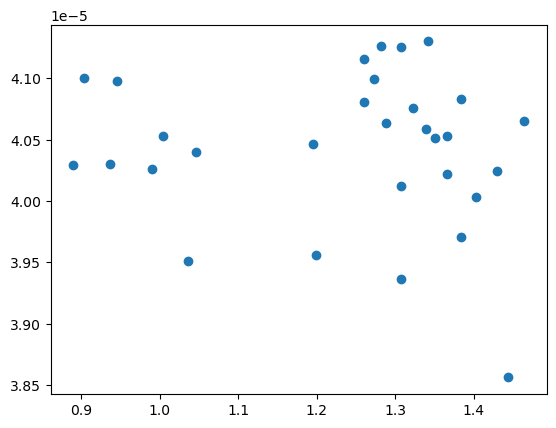

In [16]:
plt.scatter(df_distances_30['dist_from_center'], df_distances_30['distances'])

In [49]:
#QUESTO È SBAGLIATO AL MOMENTO!!! STO PLOTTANDO NEL PIANO ENGENEERING E NON NEL DVCS

# detectors_to_rotate = [36, 56, 143]
# for seqnum in [92]:

#     # _84 indica le proprietà in quelle situazioni nelle quali la camera è stata ruotata di 30°
#     xx_star_all_cam_84 = []
#     yy_star_all_cam_84 = []
#     ra_star_all_cam_84 = []
#     dec_star_all_cam_84 = []

#     e_det_output_84_rot = []
#     ex_det_output_84_rot = []
#     ey_det_output_84_rot = []
#     ex_rot_cam_output_84_rot = []
#     ey_rot_cam_output_84_rot = []
#     theta_cam_output_84_rot = []
#     xx_cam_output_84_rot = [] #coordinate x su detector
#     yy_cam_output_84_rot = [] #coordinate x su detector
#     xx_mm_cam_output_84_rot = [] #coordinate x su camera
#     yy_mm_cam_output_84_rot = [] #coordinate y su camera
#     seqnum_cam_output_84_rot = []
#     detector_cam_output_84_rot = []
#     xx_star_all_cam_84_rot = []
#     yy_star_all_cam_84_rot = []

#     x_center_detector_cam = []
#     y_center_detector_cam = []
    
#     for detector in detectors_to_rotate:
        
#         visit_seqnum = 5023071800000 + seqnum
        
#         print(seqnum, detector)

#         collection = collection_dict[seqnum]

#         # Create the butler
#         butler = dafButler.Butler(config,collections=collection)

#         #Adesso dobbiammo dire al butler che tipo di dati vogliamo.
#         #La call si fa chiedendo un datasetType (e.g., deepCoadd, calexp, objectTable) e un data ID(is a dictionary-like identifier for a specific data product)
#         #Qui piu' informazioni sul butler 
#         #https://github.com/rubin-dp0/tutorial-notebooks/blob/main/04b_Intermediate_Butler_Queries.ipynb

#         datasetType='calexp'
#         dataId = {'visit': visit_seqnum, 'detector': detector, 'band':'r'}
#         calexp = butler.get(datasetType, **dataId)
#         sources = butler.get('src', dataId)
#         psf = calexp.getPsf()
#         bkgd = butler.get('calexpBackground', **dataId)
#         ccd = calexp.detector.getId()
#         det = calexp.getDetector()
#         wcs = calexp.getWcs()
#         calexp_info = calexp.getInfo()

#         rot = (calexp.info.getVisitInfo().getBoresightRotAngle()).asDegrees()
#         rot_from_imsim = 30
#         rotfwd = 0. - rot_from_imsim
#         # rot = 150
#         # rotfwd = rot - 180.
#         # assert False

#         point = geom.Point2D(x_centro_detector, y_centro_detector)
#         cam_x, cam_y = pixel_to_camera_angle(point[0], point[1], det)
#         x_center_detector_cam.append(cam_x)
#         y_center_detector_cam.append(cam_y)
        
#         ################
#         # Mappa di stelle sul piano focale
#         ################

#         if True:
#             xx_star = [l.getCentroid()[0] for l in sources]
#             yy_star = [l.getCentroid()[1] for l in sources]
#             ra_star = [l.getRa().asDegrees() for l in sources]
#             dec_star = [l.getDec().asDegrees() for l in sources]

#             for xxx, yyy, raa, decc in zip(xx_star, yy_star, ra_star, dec_star):
#                 point = geom.Point2D(xxx, yyy)
#                 cam_x, cam_y = pixel_to_camera_angle(point[0], point[1], det)
#                 xx_star_all_cam_84.append(cam_x[0])
#                 yy_star_all_cam_84.append(cam_y[0])
#                 ra_star_all_cam_84.append(raa)
#                 dec_star_all_cam_84.append(decc)

#                 # DEVO FARE LE ROTAZIONI UNA ALLA VOLTA, ALTRIMENTI, SE ESCO DAL CICLO FOR DEI DETECTOR
#                 # NON POTREI USRE UN wcs UNICO PER TUTTI I PUNTI
#                 xxx_temp = np.asarray(cam_x[0])*np.cos(np.radians(rotfwd)) - \
#                                           np.asarray(cam_y[0])*np.sin(np.radians(rotfwd))
#                 yyy_temp = np.asarray(cam_x[0])*np.sin(np.radians(rotfwd)) + \
#                                           np.asarray(cam_y[0])*np.cos(np.radians(rotfwd))
#                 xx_star_all_cam_84_rot.append(xxx_temp)
#                 yy_star_all_cam_84_rot.append(yyy_temp)
                
#                 point = geom.Point2D(xxx_temp, yyy_temp)
#                 coo = wcs.pixelToSky(xxx_temp, yyy_temp)
#                 Ixx = psf.computeShape(point).getIxx()
#                 Iyy = psf.computeShape(point).getIyy()
#                 Ixy = psf.computeShape(point).getIxy()
#                 theta = np.arctan2(2. * Ixy, Ixx - Iyy) / 2.
#                 e1 = (Ixx - Iyy) / (Ixx + Iyy)
#                 e2 = (2. * Ixy) / (Ixx + Iyy)
#                 e = np.sqrt(e1**2 + e2**2)
#                 ex = e * np.cos(theta)
#                 ey = e * np.sin(theta)
#                 theta_cam = np.arctan2(ex, ey) #IMPORTANTE INVERTIRE XY TRA DETECTOR E FP
                
#                 e_det_output_84_rot.append(e)
#                 ex_det_output_84_rot.append(ey) #IMPORTANTE INVERTIRE XY TRA DETECTOR E FP
#                 ey_det_output_84_rot.append(ex) #IMPORTANTE INVERTIRE XY TRA DETECTOR E FP
#                 theta_cam_output_84_rot.append(theta_cam)
#                 xx_cam_output_84_rot.append(coo[1].asDegrees()) #IMPORTANTE INVERTIRE XY TRA DETECTOR E FP
#                 yy_cam_output_84_rot.append(coo[0].asDegrees()) #IMPORTANTE INVERTIRE XY TRA DETECTOR E FP
#                 xx_mm_cam_output_84_rot.append(cam_y[0]) #IMPORTANTE INVERTIRE XY TRA DETECTOR E FP
#                 yy_mm_cam_output_84_rot.append(cam_x[0]) #IMPORTANTE INVERTIRE XY TRA DETECTOR E FP
#                 seqnum_cam_output_84_rot.append(seqnum)
#                 detector_cam_output_84_rot.append(detector)
    
#     x_center_detector_cam_rot = np.asarray(x_center_detector_cam)*np.cos(np.radians(rotfwd)) - \
#                                  np.asarray(y_center_detector_cam)*np.sin(np.radians(rotfwd))
#     y_center_detector_cam_rot = np.asarray(x_center_detector_cam)*np.sin(np.radians(rotfwd)) + \
#                                  np.asarray(y_center_detector_cam)*np.cos(np.radians(rotfwd))
    
#     fig = plt.figure(figsize=(15, 15))
#     plt.scatter(xx_star_all_cam, yy_star_all_cam, s=.3)
#     plt.scatter(xx_star_all_cam_84, yy_star_all_cam_84, s=.3, c='k')
#     plt.scatter(xx_star_all_cam_84_rot, yy_star_all_cam_84_rot, s=.3, c='r')

#     for i in np.arange(3):
#         plt.text(x_center_detector_cam[i], y_center_detector_cam[i], detectors_to_rotate[i], fontsize=8)
#         plt.text(x_center_detector_cam_rot[i], y_center_detector_cam_rot[i], detectors_to_rotate[i], fontsize=8)
    
#     plt.xlim([-2,2])
#     plt.ylim([-2,2])
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.title('Grid of stars')
#     plt.show()
#     fig.savefig(folderout+"figures/check_rotation_150_nolabels.{:s}".format(format_figures))
#     remove_figure(fig)

#     fig = plt.figure(figsize=(15, 15))
#     plt.quiver(xx_mm_cam_output_selected, yy_mm_cam_output_selected, 
#                ex_det_output_selected, ey_det_output_selected, e_det_output_selected,  
#            scale=2., headlength=0., headwidth=1., pivot='mid', linewidths=.01, alpha=.3)

#     plt.quiver(xx_mm_cam_output_84_rot, yy_mm_cam_output_84_rot, 
#                ex_det_output_84_rot, ey_det_output_84_rot, e_det_output_84_rot,  
#            scale=2., headlength=0., headwidth=1., pivot='mid', linewidths=.01, width=.001)
    
#     plt.xlim([-2,2])
#     plt.ylim([-2,2])
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.title('Ellipticity Sticks')
#     colorbar = plt.colorbar(label='ellipticity')
#     plt.clim(0., max(e_det_output_selected))
#     fig.savefig(folderout+"figures/check_rotation_150_nolabels_ellipticitysticks.{:s}".format(format_figures))
#     remove_figure(fig)


In [69]:
do_make_figures_calexp = True
do_make_ellipticity_in_the_center = True
do_make_mean_ellipticity = True
do_ellipticity_on_focalplane = True
regular_grid_or_star_positions = 1 # parametro per l'ellitticità su singolo detector 0: calcolo e su griglia; 1: calcolo e su posizioni stelle
n_grid = 3

do_figure_wcs = False
do_figure_bkg = False
do_figure_psf = False
do_fits_preview = False

# OUTPUT ELLITTICITÀ MEDIE SUI DETECTOR
detector_output = []
seqnum_output = []
mean_e_output = []
median_e_output = []
std_e_output = []
min_e_output = []
max_e_output = []
xx_mean_output = []
yy_mean_output = []
xx_mm_output = []
yy_mm_output = []

x_centro_detector = 2000.
y_centro_detector = 2000.

for seqnum in [59]:

    xx_star_all_cam = []
    yy_star_all_cam = []    
    ra_star_all_cam = []
    dec_star_all_cam = []
    
    for detector in detectors:
        
        visit_seqnum = 5023071800000 + seqnum
        
        print(seqnum, detector)

        collection = collection_dict[seqnum]

        # Create the butler
        butler = dafButler.Butler(config,collections=collection)

        #Adesso dobbiammo dire al butler che tipo di dati vogliamo.
        #La call si fa chiedendo un datasetType (e.g., deepCoadd, calexp, objectTable) e un data ID(is a dictionary-like identifier for a specific data product)
        #Qui piu' informazioni sul butler 
        #https://github.com/rubin-dp0/tutorial-notebooks/blob/main/04b_Intermediate_Butler_Queries.ipynb

        datasetType='calexp'
        dataId = {'visit': visit_seqnum, 'detector': detector, 'band':'r'}
        calexp = butler.get(datasetType, **dataId)
        sources = butler.get('src', dataId)
        psf = calexp.getPsf()
        bkgd = butler.get('calexpBackground', **dataId)
        ccd = calexp.detector.getId()
        det = calexp.getDetector()
        wcs = calexp.getWcs()
        calexp_info = calexp.getInfo()

        rot = (calexp.info.getVisitInfo().getBoresightRotAngle()).asDegrees()

        ################
        # Mappa di stelle sul piano focale
        ################

        if True:
            xx_star = [l.getCentroid()[0] for l in sources]
            yy_star = [l.getCentroid()[1] for l in sources]
            ra_star = [l.getRa().asDegrees() for l in sources]
            dec_star = [l.getDec().asDegrees() for l in sources]

            for xxx, yyy, raa, decc in zip(xx_star, yy_star, ra_star, dec_star):
                point = geom.Point2D(xxx, yyy)
                cam_x, cam_y = pixel_to_camera_angle(point[0], point[1], det)
                xx_star_all_cam.append(cam_x[0])
                yy_star_all_cam.append(cam_y[0])
                ra_star_all_cam.append(raa)
                dec_star_all_cam.append(decc)

59 0
59 1
59 2
59 3
59 4
59 5
59 6
59 7
59 8
59 9
59 10
59 11
59 12
59 13
59 14
59 15
59 16
59 17
59 18
59 19
59 20
59 21
59 22
59 23
59 24
59 26
59 27
59 28
59 29
59 30
59 31
59 32
59 33
59 34
59 35
59 36
59 37
59 38
59 39
59 40
59 41
59 42
59 43
59 44
59 45
59 46
59 47
59 48
59 49
59 50
59 51
59 52
59 53
59 54
59 55
59 56
59 57
59 58
59 59
59 60
59 61
59 62
59 63
59 64
59 65
59 66
59 67
59 68
59 69
59 70
59 71
59 72
59 73
59 74
59 75
59 76
59 77
59 78
59 79
59 80
59 81
59 82
59 83
59 84
59 85
59 86
59 87
59 88
59 89
59 90
59 91
59 92
59 93
59 94
59 95
59 96
59 97
59 98
59 99
59 100
59 101
59 102
59 103
59 104
59 105
59 106
59 107
59 108
59 109
59 110
59 111
59 112
59 113
59 114
59 115
59 116
59 117
59 118
59 119
59 120
59 121
59 122
59 123
59 124
59 125
59 126
59 127
59 128
59 129
59 130
59 131
59 132
59 133
59 134
59 135
59 136
59 137
59 138
59 139
59 140
59 141
59 142
59 143
59 144
59 145
59 146
59 147
59 148
59 149
59 150
59 151
59 152
59 153
59 154
59 155
59 156
59 157
59 158
59 

In [ ]:
detectors_to_rotate = [36, 56, 143]
for seqnum in [92]:

    xx_star_all_cam_84 = []
    yy_star_all_cam_84 = []
    ra_star_all_cam_84 = []
    dec_star_all_cam_84 = []

    x_center_detector_cam = []
    y_center_detector_cam = []
    
    for detector in detectors_to_rotate:
        
        visit_seqnum = 5023071800000 + seqnum
        
        print(seqnum, detector)

        collection = collection_dict[seqnum]

        # Create the butler
        butler = dafButler.Butler(config,collections=collection)

        #Adesso dobbiammo dire al butler che tipo di dati vogliamo.
        #La call si fa chiedendo un datasetType (e.g., deepCoadd, calexp, objectTable) e un data ID(is a dictionary-like identifier for a specific data product)
        #Qui piu' informazioni sul butler 
        #https://github.com/rubin-dp0/tutorial-notebooks/blob/main/04b_Intermediate_Butler_Queries.ipynb

        datasetType='calexp'
        dataId = {'visit': visit_seqnum, 'detector': detector, 'band':'r'}
        calexp = butler.get(datasetType, **dataId)
        sources = butler.get('src', dataId)
        psf = calexp.getPsf()
        bkgd = butler.get('calexpBackground', **dataId)
        ccd = calexp.detector.getId()
        det = calexp.getDetector()
        wcs = calexp.getWcs()
        calexp_info = calexp.getInfo()

        rot = (calexp.info.getVisitInfo().getBoresightRotAngle()).asDegrees()
        print(rot)

        point = geom.Point2D(x_centro_detector, y_centro_detector)
        cam_x, cam_y = pixel_to_camera_angle(point[0], point[1], det)
        x_center_detector_cam.append(cam_x)
        y_center_detector_cam.append(cam_y)
        
        ################
        # Mappa di stelle sul piano focale
        ################

        if True:
            xx_star = [l.getCentroid()[0] for l in sources]
            yy_star = [l.getCentroid()[1] for l in sources]
            ra_star = [l.getRa().asDegrees() for l in sources]
            dec_star = [l.getDec().asDegrees() for l in sources]

            for xxx, yyy, raa, decc in zip(xx_star, yy_star, ra_star, dec_star):
                point = geom.Point2D(xxx, yyy)
                cam_x, cam_y = pixel_to_camera_angle(point[0], point[1], det)
                xx_star_all_cam_84.append(cam_x[0])
                yy_star_all_cam_84.append(cam_y[0])
                ra_star_all_cam_84.append(raa)
                dec_star_all_cam_84.append(decc)

    # rot = 150
    rotfwd = rot - 180.
    xx_star_all_cam_84_rot = np.asarray(xx_star_all_cam_84)*np.cos(np.radians(rotfwd)) - \
                              np.asarray(yy_star_all_cam_84)*np.sin(np.radians(rotfwd))
    yy_star_all_cam_84_rot = np.asarray(xx_star_all_cam_84)*np.sin(np.radians(rotfwd)) + \
                              np.asarray(yy_star_all_cam_84)*np.cos(np.radians(rotfwd))

    x_center_detector_cam_rot = np.asarray(x_center_detector_cam)*np.cos(np.radians(rotfwd)) - \
                                 np.asarray(y_center_detector_cam)*np.sin(np.radians(rotfwd))
    y_center_detector_cam_rot = np.asarray(x_center_detector_cam)*np.sin(np.radians(rotfwd)) + \
                                 np.asarray(y_center_detector_cam)*np.cos(np.radians(rotfwd))
    
    fig = plt.figure(figsize=(15, 15))
    plt.scatter(xx_star_all_cam, yy_star_all_cam, s=.3)
    plt.scatter(xx_star_all_cam_84, yy_star_all_cam_84, s=.3, c='k')
    plt.scatter(xx_star_all_cam_84_rot, yy_star_all_cam_84_rot, s=.3, c='r')

    # for xx,yy,ra,dec in zip(xx_star_all_cam,yy_star_all_cam,ra_star_all_cam,dec_star_all_cam):
    #     plt.text(xx, yy, '{:10.6f}'.format(ra), fontsize='xx-small', c='b')
    #     plt.text(xx, yy-.01, '{:10.6f}'.format(dec), fontsize='xx-small', c='b')
    # for xx,yy,ra,dec in zip(xx_star_all_cam_84_rot,yy_star_all_cam_84_rot,ra_star_all_cam_84,dec_star_all_cam_84):
    #     plt.text(xx, yy-.02, '{:10.6f}'.format(ra), fontsize='xx-small', c='r')
    #     plt.text(xx, yy-.03, '{:10.6f}'.format(dec), fontsize='xx-small', c='r')

    for i in np.arange(3):
        plt.text(x_center_detector_cam[i], y_center_detector_cam[i], detectors_to_rotate[i], fontsize=8)
        plt.text(x_center_detector_cam_rot[i], y_center_detector_cam_rot[i], detectors_to_rotate[i], fontsize=8)
    
    plt.xlim([-2,2])
    plt.ylim([-2,2])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Ellipticity Sticks')
    plt.show()
    fig.savefig(folderout+"figures/check_rotation_calexp_nolabels.{:s}".format(format_figures))
    remove_figure(fig)

In [30]:
## Adesso cerco di capire quale sia l'offset tra le ruotate e le originali

distances = []
deltax = []
deltay = []
for xx_temp, yy_temp in zip(xx_star_all_cam_84_rot, yy_star_all_cam_84_rot):
    df_temp = pd.DataFrame(data={})
    df_temp['deltax'] = xx_temp - xx_star_all_cam
    df_temp['deltay'] = yy_temp - yy_star_all_cam
    df_temp['dist_temp'] = np.sqrt( (df_temp['deltax'])**2 + (df_temp['deltay'])**2 )
    ind_min = df_temp['dist_temp'] == min(df_temp['dist_temp'])
    distances.append(df_temp['dist_temp'][ind_min].values[0])
    deltax.append(df_temp['deltax_arcsec'][ind_min].values[0]*3600)
    deltay.append(df_temp['deltay_arcsec'][ind_min].values[0]*3600)

df_distances = pd.DataFrame(data={})
df_distances['xx_star_all_cam_84_rot'] = xx_star_all_cam_84_rot
df_distances['yy_star_all_cam_84_rot'] = yy_star_all_cam_84_rot
df_distances['deltax'] = deltax
df_distances['deltay'] = deltay
df_distances['distances'] = distances

print(df_distances)

    xx_star_all_cam_84_rot  yy_star_all_cam_84_rot    deltax    deltay  \
0                -1.287107               -0.458231 -0.074088  0.125411   
1                -1.414102               -0.378807 -0.070583  0.129118   
2                -1.223755               -0.457842 -0.077322  0.131118   
3                -1.350795               -0.378533 -0.072112  0.123941   
4                -1.287500               -0.378203 -0.072435  0.129582   
5                -1.224217               -0.377821 -0.074150  0.129533   
6                -1.351122               -0.298505 -0.071711  0.125921   
7                -1.287897               -0.298182 -0.074279  0.126734   
8                -1.224684               -0.297807 -0.074146  0.126829   
9                -1.161482               -0.297378 -0.072355  0.123276   
10               -1.288298               -0.218165 -0.073434  0.126810   
11                0.320328               -1.392799 -0.073613  0.128656   
12                0.384414            

NameError: name 'xx' is not defined

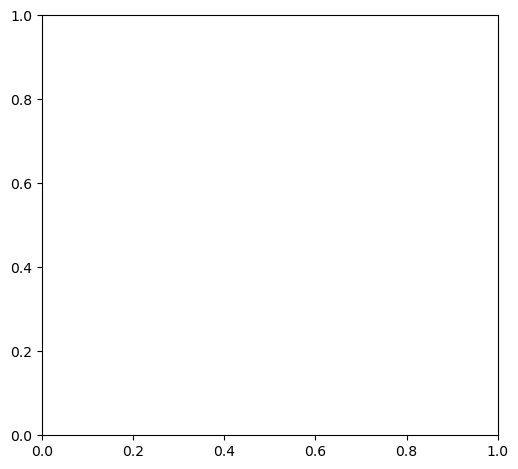

In [19]:
fig = plt.figure(figsize=(20, 12))
plt.subplots_adjust(wspace=0.2)

plt.subplot(2, 3, 1)
plt.quiver(xx, yy, ex, ey, e, headlength=0., headwidth=1., pivot='mid', width=0.01)
#plt.quiver(xx, yy, scale=e, angles=phi, headlength=0., headwidth=1., pivot='mid', width=0.005)
#colorbar = plt.colorbar(label='r$\sqrt(e1^{2} + e2^{2})$')
colorbar = plt.colorbar(label='e')
plt.clim(0., 0.05)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Ellipticity Sticks')

plt.subplot(2, 3, 2)
plt.scatter(xx, yy, c=e1, vmin=-0.05, vmax=0.05, cmap='bwr')
colorbar = plt.colorbar(label='e1')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Value of e1')

plt.subplot(2, 3, 3)
plt.scatter(xx, yy, c=e2, vmin=-0.05, vmax=0.05, cmap='bwr')
colorbar = plt.colorbar(label='e2')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Value of e2')

plt.subplot(2, 3, 4)
plt.scatter(xx, yy, c=size)
colorbar = plt.colorbar(label='Trace Radius')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trace Radius');

plt.subplot(2, 3, 5)
plt.scatter(xx, yy, c=fwhm)
colorbar = plt.colorbar(label='FWHM')
plt.xlabel('x')
plt.ylabel('y')
plt.title('FWHM');

# fig.savefig(folderout+subfolderout_fig+'ellipticity_map_seqnum.pdf')

In [ ]:
fig = plt.figure(figsize=(10, 8))
plt.subplots_adjust(wspace=0.5)

plt.quiver(xx, yy, ex, ey, e, headlength=0., headwidth=1., pivot='mid', width=0.003)
#plt.quiver(xx, yy, scale=e, angles=phi, headlength=0., headwidth=1., pivot='mid', width=0.005)
#colorbar = plt.colorbar(label='r$\sqrt(e1^{2} + e2^{2})$')
colorbar = plt.colorbar(label='e')
plt.clim(0., 0.05)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Ellipticity Sticks')

Text(0.5, 1.0, 'Ellipticity Sticks')

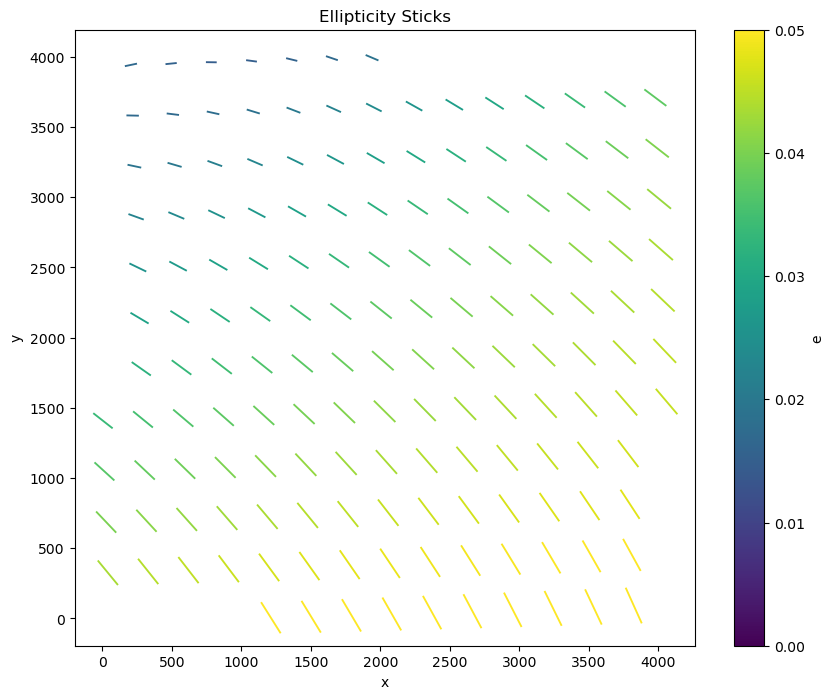

In [29]:
fig = plt.figure(figsize=(10, 8))
plt.subplots_adjust(wspace=0.5)

plt.quiver(xx, yy, ex, ey, e, headlength=0., headwidth=1., pivot='mid', width=0.003)
#plt.quiver(xx, yy, scale=e, angles=phi, headlength=0., headwidth=1., pivot='mid', width=0.005)
#colorbar = plt.colorbar(label='r$\sqrt(e1^{2} + e2^{2})$')
colorbar = plt.colorbar(label='e')
plt.clim(0., 0.05)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Ellipticity Sticks')

In [67]:
.00004*3600.

0.14400000000000002